# Microglia Pseudotime Analysis

### for K. Evans, K. Blake, A. Longsworth, _et al.,_ 
### Nature Cell Biology 2023

In [1]:
library(Seurat) #version: 4.1.0
library(SeuratWrappers) #version: 0.3.0
library(viridis) #version: 0.6.2
library(ggplot2) #version: 3.3.5
library(monocle3) #version: 1.2.9

Attaching SeuratObject

Loading required package: viridisLite

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: SingleCellExperiment

Loading required package: SummarizedExper

In [2]:
# set random seed for reproducibility
# note the supplementary computing infrastructure info at the end
set.seed(4837)

In [3]:
#load Seurat object and convert to Monocle3 cds
rna <- readRDS("BL6_RAG_microglia_small_timecourse_doublets_removed.rds")
cds <- as.cell_data_set(rna)

Warning message:
“Monocle 3 trajectories require cluster partitions, which Seurat does not calculate. Please run 'cluster_cells' on your cell_data_set object”


In [4]:
#perform standard data processing
cds <- preprocess_cds(cds)
cds <- reduce_dimension(cds)

No preprocess_method specified, using preprocess_method = 'PCA'



In [5]:
# clustering resolution of 3e-4 was the closest to Seurat clusters
cds <- cluster_cells(cds, resolution=3e-4)

In [6]:
cds <- learn_graph(cds, use_partition = FALSE, verbose = FALSE)

  |======================================================================| 100%


Warning message in igraph::graph.dfs(stree_ori, root = root_cell, neimode = "all", :
“Argument `neimode' is deprecated; use `mode' instead”


In [7]:
# function for selecting pseudotime start
# selected vertex with the highest proportion wildtype day 4 cells

get_earliest_principal_node <- function(cds, time_bin="WT_D4"){
  cell_ids <- which(colData(cds)[, "timepoint_strain"] == "D4_BL6")

  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
    igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
   (which.max(table(closest_vertex[cell_ids,]))))]

  root_pr_nodes
}

In [8]:
# perform pseudotime cell ordering
cds <- order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

In [9]:
# extract pseudotime results and add to the original Seurat object for plotting
rna.mono <- as.Seurat(cds, assay = NULL)
pseudotime <- as.data.frame(rna.mono$monocle3_pseudotime)
rownames(pseudotime) <- rownames(rna.mono@meta.data)
colnames(pseudotime) <- "pseudotime"
pseudotime <- as.data.frame(pseudotime)
rna <- AddMetaData(rna,pseudotime)

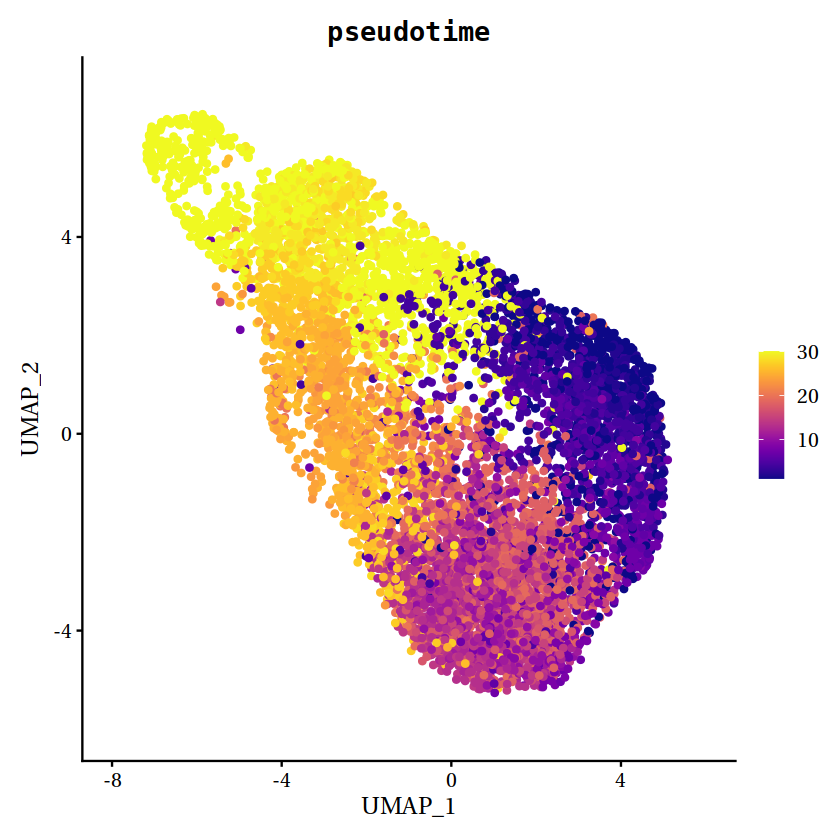

In [10]:
# Make a pseudotime featureplot  

pal <- viridis(n = 30, option = "C")
FeaturePlot(rna, "pseudotime", cols=pal, pt.size=1.4)

In [11]:
# set clusters order for the violin plot
Idents(rna) <- "microglia_named_clusters"
levels(rna) <- c("Homeostatic", "Secretory", "Ifn.Responsive", "APC", "Cycling")

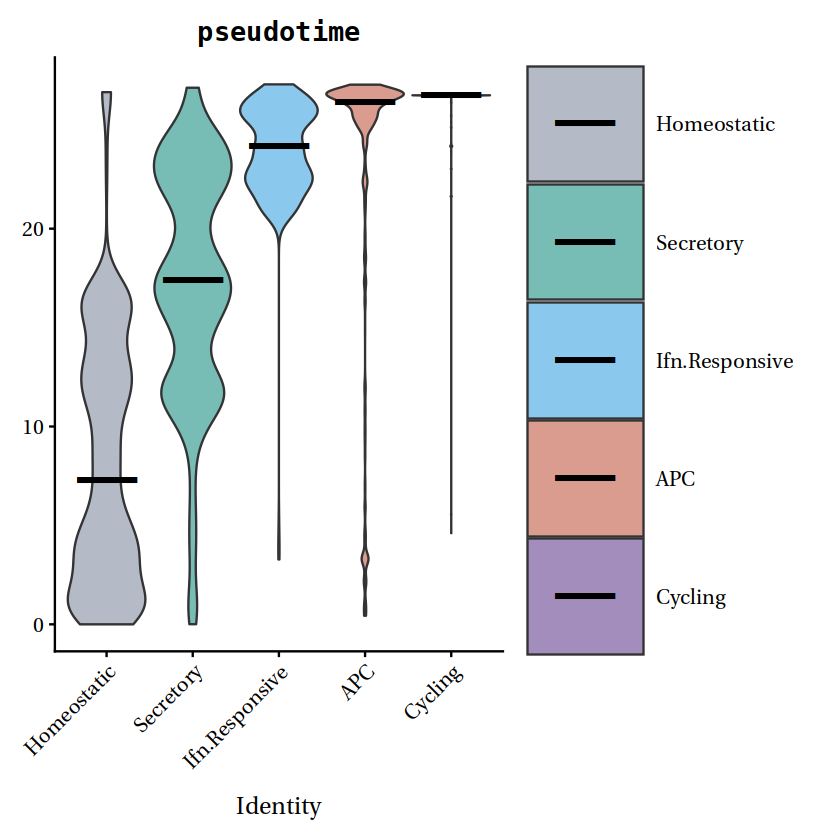

In [12]:
# display pseudotime as violins with median bars, colored the same as in original Seurat plots
color_list <- c('#B5BAC7','#77BDB6','#8BC8EE','#DB9C90','#A38DBC')
VlnPlot(rna, "pseudotime", pt.size = 0, cols = color_list) +
    stat_summary(fun = median, geom='point', size = 25, colour = "black", shape = 95)


# Supplementary Bioinformatics Info

##### UC Irvine RCIC biojhub4 singularity container: [Rocky8][DEBUG]ATACsSeq Bioinformatics
##### CPU cores: 6
##### memory per CPU: 6